# Models

In [50]:
import math 
import random
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, f1_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm

# Dataset

The provided information through RAPL:

test - PKG - CPU - GPU - DRAM - Time

Due to it being two different datasets with different codes but similar test names we add the features before we merge the datasets


In [29]:
df = pd.read_csv('C.csv')

# Cleaning C dataset
df.columns =['test','CPU','GPU','DRAM','Time']
df[['Test', 'PKG']] = df['test'].str.split('; ', expand=True)
df = df[['Test', 'PKG', 'CPU', 'Time', 'GPU', 'DRAM', 'test']]
df = df.drop(columns=['GPU','DRAM','test'])

# Because of PKG and Test being seperated, PKG must become float
df.PKG = df.PKG.astype(float)
# print (df.dtypes)

#Adjusting dataset and adding features
# C = 1, GCC = 1
df = df.sort_values(by=['Test'])
df['Code']= 'C'
df['Compiler'] = 'GCC 11.2.0'
df['Code_Type']= '1'
df['Compiler_Type'] = '1'

df['Code_Type'] = pd.Categorical(df['Code_Type'], categories=['1', '2'], ordered=True)
df['Compiler_Type'] = pd.Categorical(df['Compiler_Type'], categories=['1', '2'], ordered=True)

# Define mappings as dictionaries

df['Time_comp'] = ''
df['Space_comp'] = ''
df['Nested_loops'] = ''
df['Simple_cond'] = ''
df['Complex_cond'] = ''
df['Recursion_calls'] = ''

Time_comp_mapping = {
    'binary-trees ': 'O(d x 2^d)', 'bubblesort ': 'O(n^2)', 'bubblesort_func ': 'O(n^2)', 'bubblesort_ll ': 'O(n^2)', 'bubblesort_ll2 ': 'O(n^2)', 'fannkuch-redux ': 'O(n!)', 'fasta ': 'O(n x m)', 'k-nucleotide ': 'O(n+k log k)', 'mandelbrot ': 'O(n^2)', 'n-body ': '(n x nboddies^2)', 'pidigits ': 'O(n^2 log n log log n)', 'regex-redux ': 'O(n*p)', 'reverse-complement ': 'O(n + p x m)', 'spectral-norm ': 'O(n^2/T)' 
}
time_complexity_mapping = {
    'O(1)': 1, 'O(log n)': 2, 'O(n)': 3, 'O(n log n)': 4, 'O(n+k log k)': 5, 'O(n x m)': 6, 'O(n*p)': 7, 'O(n^2)': 8, 'O(n^2/T)': 9, 'O(n^2 log n log log n)': 10, 'O(n x nboddies^2)': 11, 'O(2^n)': 12, 'O(n!)': 13, 'O(d x 2^d)': 14, 'O(m x t x d^2)': 15, 'O(w^2 x k)': 16, 'O(n x m^2)': 17, 'O(n x z^2)': 18
}

Space_comp_mapping = {
    'binary-trees ': 'O(2^d)', 'bubblesort ': 'O(1)', 'bubblesort_func ': 'O(1)', 'bubblesort_ll ': 'O(1)', 'bubblesort_ll2 ': 'O(1)', 'fannkuch-redux ': 'O(n)', 'fasta ': 'O(n)', 'k-nucleotide ': 'O(n+k)', 'mandelbrot ': 'O(n^2)', 'n-body ': 'O(nbodies^2)', 'pidigits ': 'O(n)', 'regex-redux ': 'O(n)', 'reverse-complement ': 'O(n)', 'spectral-norm ': 'O(n)' 
}
space_complexity_mapping = {
  'O(1)': 1, 'O(log n)': 2, 'O(n)': 3, 'O(n+k)': 4, 'O(n^2)': 5, 'O(nbodies^2)': 6, 'O(2^n)': 7, 'O(n!)': 8, 'O(2^d)': 9, 'O(w^2)': 10, 'O(m)': 11
}


Nested_loops_mapping = {
    'binary-trees ': 2, 'bubblesort ': 2, 'bubblesort_func ': 2, 'bubblesort_ll ': 2, 'bubblesort_ll2 ': 2, 'fannkuch-redux ': 3, 'fasta ': 2, 'k-nucleotide ': 2, 'mandelbrot ': 3, 'n-body ': 6, 'pidigits ': 1, 'regex-redux ': 1, 'reverse-complement ': 2, 'spectral-norm ': 2 
}

Simple_cond_mapping = {
    'binary-trees ': 3, 'bubblesort ': 1, 'bubblesort_func ': 1, 'bubblesort_ll ': 2, 'bubblesort_ll2 ': 2, 'fannkuch-redux ': 4, 'fasta ': 6, 'k-nucleotide ': 9, 'mandelbrot ': 13, 'n-body ': 11, 'pidigits ': 3, 'regex-redux ': 2, 'reverse-complement ': 4, 'spectral-norm ': 1 
}

Complex_cond_mapping = {
    'binary-trees ': 0, 'bubblesort ': 0, 'bubblesort_func ': 0, 'bubblesort_ll ': 0, 'bubblesort_ll2 ': 0, 'fannkuch-redux ': 0, 'fasta ': 0, 'k-nucleotide ': 4, 'mandelbrot ': 9, 'n-body ': 0, 'pidigits ': 0, 'regex-redux ': 0, 'reverse-complement ': 0, 'spectral-norm ': 0 
}

Recursion_call_mapping = {
    'binary-trees ': 2, 'bubblesort ': 0, 'bubblesort_func ': 0, 'bubblesort_ll ': 0, 'bubblesort_ll2 ': 0, 'fannkuch-redux ': 0, 'fasta ': 0, 'k-nucleotide ': 0, 'mandelbrot ': 0, 'n-body ': 0, 'pidigits ': 0, 'regex-redux ': 0, 'reverse-complement ': 0, 'spectral-norm ': 0
}

Source_LOC_mapping = {
    'binary-trees ': 102, 'bubblesort ': 50, 'bubblesort_func ': 41, 'bubblesort_ll ': 81, 'bubblesort_ll2 ': 76, 'fannkuch-redux ': 275, 'fasta ': 317, 'k-nucleotide ': 287, 'mandelbrot ': 177, 'n-body ': 146, 'pidigits ': 52, 'regex-redux ': 130, 'reverse-complement ': 125, 'spectral-norm ': 183
}

NR_functions_mapping = {
    'binary-trees ': 3, 'bubblesort ': 2, 'bubblesort_func ': 3, 'bubblesort_ll ': 6, 'bubblesort_ll2 ': 5, 'fannkuch-redux ': 11, 'fasta ': 13, 'k-nucleotide ': 5, 'mandelbrot ': 7, 'n-body ': 6, 'pidigits ': 4, 'regex-redux ': 3, 'reverse-complement ': 2, 'spectral-norm ': 9
}

NR_param_mapping = {
    'binary-trees ': 5, 'bubblesort ': 4, 'bubblesort_func ': 4, 'bubblesort_ll ': 7, 'bubblesort_ll2 ': 10, 'fannkuch-redux ': 26, 'fasta ': 23, 'k-nucleotide ': 12, 'mandelbrot ': 15, 'n-body ': 9, 'pidigits ': 5, 'regex-redux ': 5, 'reverse-complement ': 3, 'spectral-norm ': 13
}

cyc_comp_mapping = {
    'binary-trees ': 7, 'bubblesort ': 6, 'bubblesort_func ': 6, 'bubblesort_ll ': 10, 'bubblesort_ll2 ': 12, 'fannkuch-redux ': 83, 'fasta ': 42, 'k-nucleotide ': 29, 'mandelbrot ': 46, 'n-body ': 33, 'pidigits ': 10, 'regex-redux ': 17, 'reverse-complement ': 16, 'spectral-norm ': 28
}


df['Time_comp'] = df['Test'].map(Time_comp_mapping)
df['Space_comp'] = df['Test'].map(Space_comp_mapping)

df['Time_comp_cat'] = df['Time_comp'].map(time_complexity_mapping)
df['Space_comp_cat'] = df['Space_comp'].map(space_complexity_mapping)

# Convert the codes to categorical types with ordered categories
df['Time_comp_cat'] = pd.Categorical(df['Time_comp_cat'], categories=list(time_complexity_mapping.values()), ordered=True)
df['Space_comp_cat'] = pd.Categorical(df['Space_comp_cat'], categories=list(space_complexity_mapping.values()), ordered=True)


df['Nested_loops'] = df['Test'].map(Nested_loops_mapping)
df['Simple_cond'] = df['Test'].map(Simple_cond_mapping)
df['Complex_cond'] = df['Test'].map(Complex_cond_mapping)
df['Recursion_calls'] = df['Test'].map(Recursion_call_mapping)
df['Source_LOC'] = df['Test'].map(Source_LOC_mapping)
df['NR_functions'] = df['Test'].map(NR_functions_mapping)
df['NR_param'] = df['Test'].map(NR_param_mapping)
df['cyc_comp'] = df['Test'].map(cyc_comp_mapping)


df['Consumption'] = df['CPU'] + df['PKG']
df = df.sort_values(by=['Consumption'])
df = df.drop(df.index[df['Consumption'] < 0])

In [30]:
# Cleaning Haskell dataset
df2 = pd.read_csv('Haskell.csv', on_bad_lines='skip')

df2.columns =['test','CPU','GPU','DRAM','Time']
df2[['Test', 'PKG']] = df2['test'].str.split('; ', expand=True)
df2 = df2[['Test', 'PKG', 'CPU', 'Time', 'GPU', 'DRAM', 'test']]
df2 = df2.drop(columns=['GPU','DRAM','test'])

# # Because of PKG and Test being seperated, PKG must become float
df2.PKG = df2.PKG.astype(float)
# print(df2.dtypes)

# # Haskell = 2, GHC = 2
df2 = df2.sort_values(by=['Test'])
df2['Code']= 'Haskell'
df2['Compiler'] = 'GHC 8.10.7'
df2['Code_Type']= '2'
df2['Compiler_Type'] = '2'

# define as categorical
df2['Code_Type'] = pd.Categorical(df2['Code_Type'], categories=['1', '2'], ordered=True)
df2['Compiler_Type'] = pd.Categorical(df2['Compiler_Type'], categories=['1', '2'], ordered=True)

df2['Time_comp'] = ''
df2['Space_comp'] = ''
df2['Nested_loops'] = ''
df2['Simple_cond'] = ''
df2['Complex_cond'] = ''
df2['Recursion_calls'] = ''

Time_comp_mapping = {
    'binary-trees ': 'O(m x t x d^2)', 'bubblesort_slow ': 'O(n^2)', 'bubblesort_upd ': 'O(n^2)', 'bubblesort_upd2 ': 'O(n^2)', 'fasta ': 'O(n)', 'mandelbrot ': 'O(w^2 x k)', 'n-body ': 'O(n x m^2)', 'reverse-complement ': 'O(n x m)', 'spectral-norm ': 'O(n x z^2)'
}
time_complexity_mapping = {
    'O(1)': 1, 'O(log n)': 2, 'O(n)': 3, 'O(n log n)': 4, 'O(n+k log k)': 5, 'O(n x m)': 6, 'O(n*p)': 7, 'O(n^2)': 8, 'O(n^2/T)': 9, 'O(n^2 log n log log n)': 10, 'O(n x nboddies^2)': 11, 'O(2^n)': 12, 'O(n!)': 13, 'O(d x 2^d)': 14, 'O(m x t x d^2)': 15, 'O(w^2 x k)': 16, 'O(n x m^2)': 17, 'O(n x z^2)': 18
}

Space_comp_mapping = {
    'binary-trees ': 'O(2^d)', 'bubblesort_slow ': 'O(n^2)', 'bubblesort_upd ': 'O(n^2)', 'bubblesort_upd2 ': 'O(n^2)', 'fasta ': 'O(n)', 'mandelbrot ': 'O(w^2)', 'n-body ': 'O(m)', 'reverse-complement ': 'O(m)', 'spectral-norm ': 'O(n)'
}
space_complexity_mapping = {
    'O(1)': 1, 'O(log n)': 2, 'O(n)': 3, 'O(n+k)': 4, 'O(n^2)': 5, 'O(nbodies^2)': 6, 'O(2^n)': 7, 'O(n!)': 8, 'O(2^d)': 9, 'O(w^2)': 10, 'O(m)': 11
}

Nested_loops_mapping = {
    'binary-trees ': 2, 'bubblesort_slow ': 1, 'bubblesort_upd ': 1, 'bubblesort_upd2 ': 1, 'fasta ': 3, 'mandelbrot ': 2, 'n-body ': 2, 'reverse-complement ': 1, 'spectral-norm ': 2
}

Simple_cond_mapping = {
    'binary-trees ': 1, 'bubblesort_slow ': 1, 'bubblesort_upd ': 1, 'bubblesort_upd2 ': 2, 'fasta ': 1, 'mandelbrot ': 4, 'n-body ': 4, 'reverse-complement ': 6, 'spectral-norm ': 4
}

Complex_cond_mapping = {
    'binary-trees ': 0, 'bubblesort_slow ': 0, 'bubblesort_upd ': 0, 'bubblesort_upd2 ': 0, 'fasta ': 0, 'mandelbrot ': 0, 'n-body ': 0, 'reverse-complement ': 3, 'spectral-norm ': 0
}

Recursion_call_mapping = {
    'binary-trees ': 4, 'bubblesort_slow ': 1, 'bubblesort_upd ': 2, 'bubblesort_upd2 ': 2, 'fasta ': 2, 'mandelbrot ': 1, 'n-body ': 1, 'reverse-complement ': 0, 'spectral-norm ': 0
}

Source_LOC_mapping = {
    'binary-trees ': 40, 'bubblesort_slow ': 10, 'bubblesort_upd ': 14, 'bubblesort_upd2 ': 15, 'fasta ': 79, 'mandelbrot ': 77, 'n-body ': 166, 'reverse-complement ': 68, 'spectral-norm ': 77
}

NR_functions_mapping = {
    'binary-trees ': 6, 'bubblesort_slow ': 2, 'bubblesort_upd ': 3, 'bubblesort_upd2 ': 3, 'fasta ': 11, 'mandelbrot ': 6, 'n-body ': 12, 'reverse-complement ': 9, 'spectral-norm ': 8
}

NR_param_mapping = {
    'binary-trees ': 13, 'bubblesort_slow ': 1, 'bubblesort_upd ': 2, 'bubblesort_upd2 ': 2, 'fasta ': 17, 'mandelbrot ': 22, 'n-body ': 17, 'reverse-complement ': 14, 'spectral-norm ': 17
}

cyc_comp_mapping = {
    'binary-trees ': 13, 'bubblesort_slow ': 4, 'bubblesort_upd ': 6, 'bubblesort_upd2 ': 7, 'fasta ': 21, 'mandelbrot ': 11, 'n-body ': 20, 'reverse-complement ': 12, 'spectral-norm ': 9
}

df2['Time_comp'] = df2['Test'].map(Time_comp_mapping)
df2['Space_comp'] = df2['Test'].map(Space_comp_mapping)

df2['Time_comp_cat'] = df2['Time_comp'].map(time_complexity_mapping)
df2['Space_comp_cat'] = df2['Space_comp'].map(space_complexity_mapping)

# Convert the codes to categorical types with ordered categories
df2['Time_comp_cat'] = pd.Categorical(df2['Time_comp_cat'], categories=list(time_complexity_mapping.values()), ordered=True)
df2['Space_comp_cat'] = pd.Categorical(df2['Space_comp_cat'], categories=list(space_complexity_mapping.values()), ordered=True)

df2['Nested_loops'] = df2['Test'].map(Nested_loops_mapping)
df2['Simple_cond'] = df2['Test'].map(Simple_cond_mapping)
df2['Complex_cond'] = df2['Test'].map(Complex_cond_mapping)
df2['Recursion_calls'] = df2['Test'].map(Recursion_call_mapping)
df2['Source_LOC'] = df2['Test'].map(Source_LOC_mapping)
df2['NR_functions'] = df2['Test'].map(NR_functions_mapping)
df2['NR_param'] = df2['Test'].map(NR_param_mapping)
df2['cyc_comp'] = df2['Test'].map(cyc_comp_mapping)


df2['Consumption'] = df2['CPU'] + df2['PKG']
df2 = df2.sort_values(by=['Consumption'])
df2 = df2.drop(df2.index[df2['Consumption'] < 0])

df_merged = pd.concat([df, df2], ignore_index=True, sort=False)

new_order = ['Test', 'PKG', 'CPU', 'Time', 'Code', 'Code_Type', 'Compiler', 'Compiler_Type',
             'Time_comp', 'Time_comp_cat', 'Space_comp', 'Space_comp_cat',
             'Nested_loops', 'Simple_cond', 'Complex_cond', 'Recursion_calls', 'Source_LOC', 'NR_functions', 'NR_param', 'cyc_comp', 'Consumption']

df_merged = df_merged[new_order]
df_merged.to_csv('Merged.csv', index=False)
df_merged

,Test,PKG,CPU,Time,Code,Code_Type,Compiler,Compiler_Type,Time_comp,Time_comp_cat,...,Space_comp_cat,Nested_loops,Simple_cond,Complex_cond,Recursion_calls,Source_LOC,NR_functions,NR_param,cyc_comp,Consumption
0,k-nucleotide,0.000000,0.000000,0.673,C,1,GCC 11.2.0,1,O(n+k log k),5,...,4,2,9,4,0,287,5,12,29,0.000000
1,k-nucleotide,0.000000,0.000000,0.686,C,1,GCC 11.2.0,1,O(n+k log k),5,...,4,2,9,4,0,287,5,12,29,0.000000
2,k-nucleotide,0.000000,0.000000,0.624,C,1,GCC 11.2.0,1,O(n+k log k),5,...,4,2,9,4,0,287,5,12,29,0.000000
3,k-nucleotide,0.000000,0.000000,0.626,C,1,GCC 11.2.0,1,O(n+k log k),5,...,4,2,9,4,0,287,5,12,29,0.000000
4,k-nucleotide,0.000000,0.000000,0.672,C,1,GCC 11.2.0,1,O(n+k log k),5,...,4,2,9,4,0,287,5,12,29,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,binary-trees,523.092575,411.109070,22984.200,Haskell,2,GHC 8.10.7,2,O(m x t x d^2),15,...,9,2,1,0,4,40,6,13,13,934.201645
951,binary-trees,524.988846,413.540070,22934.500,Haskell,2,GHC 8.10.7,2,O(m x t x d^2),15,...,9,2,1,0,4,40,6,13,13,938.528915
952,binary-trees,529.029114,417.354874,22882.000,Haskell,2,GHC 8.10.7,2,O(m x t x d^2),15,...,9,2,1,0,4,40,6,13,13,946.383987
953,binary-trees,532.339172,420.933563,22912.400,Haskell,2,GHC 8.10.7,2,O(m x t x d^2),15,...,9,2,1,0,4,40,6,13,13,953.272736


#  Consumption = E_cpu + E_pkg

E_cpu = CPU x Time

E_PKG = PKG x Time
 

In [41]:
df_merged.Nested_loops = df_merged.Nested_loops.astype(float)
df_merged.Simple_cond = df_merged.Simple_cond.astype(float)
df_merged.Complex_cond = df_merged.Complex_cond.astype(float)
df_merged.Recursion_calls = df_merged.Recursion_calls.astype(float)
df_merged.Source_LOC = df_merged.Source_LOC.astype(float)
df_merged.NR_functions = df_merged.NR_functions.astype(float)
df_merged.NR_param = df_merged.NR_param.astype(float)
df_merged.cyc_comp = df_merged.cyc_comp.astype(float)
df_merged.dtypes

mu = df_merged['Consumption'].mean()
sigma = df_merged['Consumption'].std()

# Define bins to ensure coverage of the data range
# bins = [-np.inf, mu - 2*sigma, mu - sigma, mu - 0.5*sigma, mu, mu + 0.5*sigma, mu + sigma, np.inf]
# Define bins for uniform distribution using qcut
bins = pd.qcut(df_merged['Consumption'], q=7, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

# Assign the uniform distribution labels
df_merged['Energy_label'] = bins


# Categorize data into labels A to G
# df_merged['Energy_label'] = pd.cut(df_merged['Consumption'], bins=bins, labels=labels, include_lowest=True)


### Distribution of Energy labels through bins

In [32]:
bins = pd.qcut(df_merged['Consumption'], q=7, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

/tmp/ipykernel_35941/3536246102.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consumption_ranges = df_merged.groupby('Energy_label')['Consumption'].agg(['min', 'max']).reset_index()


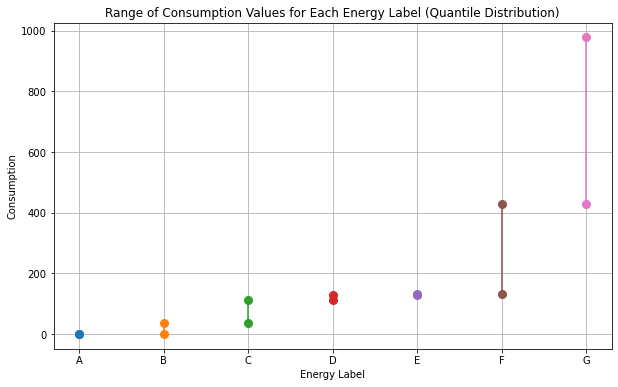

  Energy_label         min         max
0            A    0.000000    0.147263
1            B    0.147308   37.358292
2            C   37.773727  110.837799
3            D  111.423859  129.229996
4            E  129.234634  132.994919
5            F  133.080536  428.693726
6            G  429.785385  977.909271


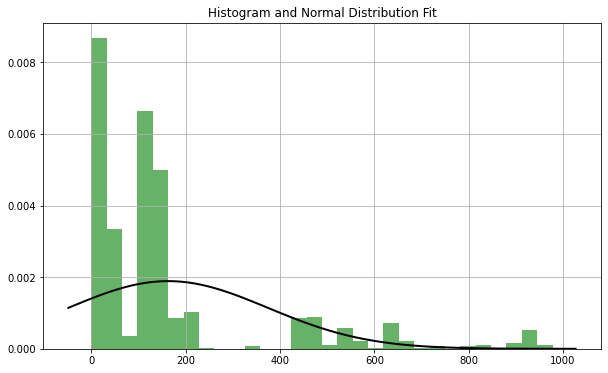

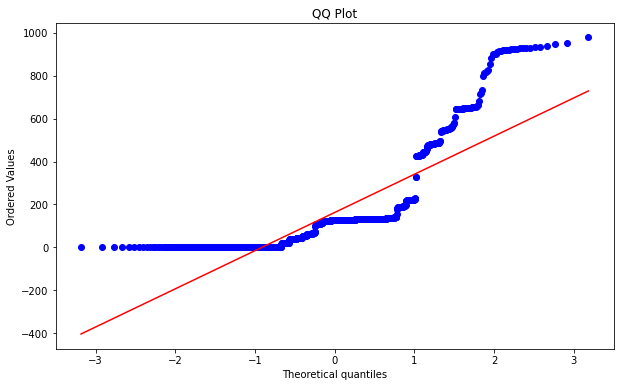

In [43]:
consumption_ranges = df_merged.groupby('Energy_label')['Consumption'].agg(['min', 'max']).reset_index()

# Plotting the ranges
plt.figure(figsize=(10, 6))
for i, label in enumerate(consumption_ranges['Energy_label']):
    plt.plot([label, label], 
             [consumption_ranges.loc[i, 'min'], consumption_ranges.loc[i, 'max']],
             marker='o', markersize=8)

plt.xlabel('Energy Label')
plt.ylabel('Consumption')
plt.title('Range of Consumption Values for Each Energy Label (Quantile Distribution)')
plt.grid(True)
plt.show()

# Display the consumption ranges for each label
print(consumption_ranges)

# Verify the fit visually using a histogram
plt.figure(figsize=(10, 6))
df_merged['Consumption'].hist(bins=30, density=True, alpha=0.6, color='g')

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, df_merged['Consumption'].mean(), df_merged['Consumption'].std())
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram and Normal Distribution Fit")
plt.show()

# QQ plot to verify normality
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(df_merged['Consumption'], dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

In [34]:
# Remove all outliers

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
        df = df.loc[filter]
    return df

# Columns to check for outliers
columns_to_check = ['PKG', 'CPU', 'Time', 'Consumption']

# Remove outliers from the merged dataframe
df_clean = remove_outliers(df_merged, columns_to_check)

df_clean.to_csv('Clean.csv', index=False)

category_counts = df_clean['Energy_label'].value_counts()
print(category_counts)


Energy_label
Benchmark    137
C            137
A            136
B            136
D            136
E            125
F              0
Name: count, dtype: int64


In [35]:
df_clean

,Test,PKG,CPU,Time,Code,Code_Type,Compiler,Compiler_Type,Time_comp,Time_comp_cat,...,Nested_loops,Simple_cond,Complex_cond,Recursion_calls,Source_LOC,NR_functions,NR_param,cyc_comp,Consumption,Energy_label
0,k-nucleotide,0.000000,0.000000,0.673,C,1,GCC 11.2.0,1,O(n+k log k),5,...,2.0,9.0,4.0,0.0,287.0,5.0,12.0,29.0,0.000000,Benchmark
1,k-nucleotide,0.000000,0.000000,0.686,C,1,GCC 11.2.0,1,O(n+k log k),5,...,2.0,9.0,4.0,0.0,287.0,5.0,12.0,29.0,0.000000,Benchmark
2,k-nucleotide,0.000000,0.000000,0.624,C,1,GCC 11.2.0,1,O(n+k log k),5,...,2.0,9.0,4.0,0.0,287.0,5.0,12.0,29.0,0.000000,Benchmark
3,k-nucleotide,0.000000,0.000000,0.626,C,1,GCC 11.2.0,1,O(n+k log k),5,...,2.0,9.0,4.0,0.0,287.0,5.0,12.0,29.0,0.000000,Benchmark
4,k-nucleotide,0.000000,0.000000,0.672,C,1,GCC 11.2.0,1,O(n+k log k),5,...,2.0,9.0,4.0,0.0,287.0,5.0,12.0,29.0,0.000000,Benchmark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,spectral-norm,123.543060,100.638535,5092.600,Haskell,2,GHC 8.10.7,2,O(n x z^2),18,...,2.0,4.0,0.0,0.0,77.0,8.0,17.0,9.0,224.181595,E
833,spectral-norm,123.885681,100.700836,5222.610,Haskell,2,GHC 8.10.7,2,O(n x z^2),18,...,2.0,4.0,0.0,0.0,77.0,8.0,17.0,9.0,224.586517,E
834,spectral-norm,124.298950,101.141052,5212.630,Haskell,2,GHC 8.10.7,2,O(n x z^2),18,...,2.0,4.0,0.0,0.0,77.0,8.0,17.0,9.0,225.440002,E
835,spectral-norm,125.376465,101.762756,5092.400,Haskell,2,GHC 8.10.7,2,O(n x z^2),18,...,2.0,4.0,0.0,0.0,77.0,8.0,17.0,9.0,227.139221,E


***Distribution of Energy Labels with clean data***

/tmp/ipykernel_35941/1981743650.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consumption_ranges = df_clean.groupby('Energy_label')['Consumption'].agg(['min', 'max']).reset_index()


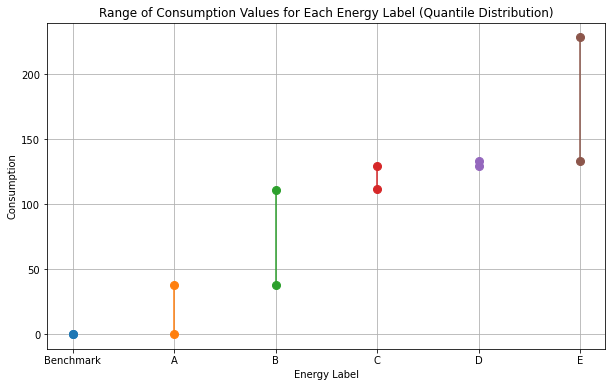

  Energy_label         min         max
0    Benchmark    0.000000    0.147263
1            A    0.147308   37.358292
2            B   37.773727  110.837799
3            C  111.423859  129.229996
4            D  129.234634  132.994919
5            E  133.080536  228.251999
6            F         NaN         NaN


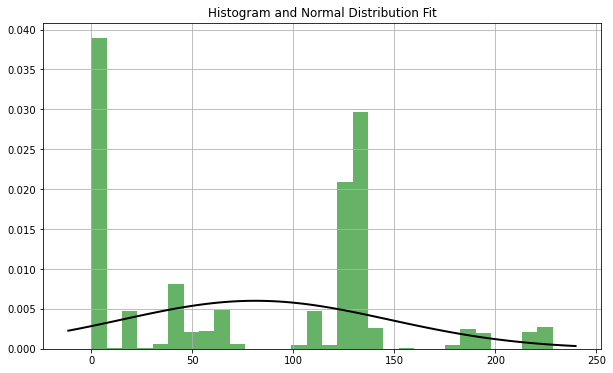

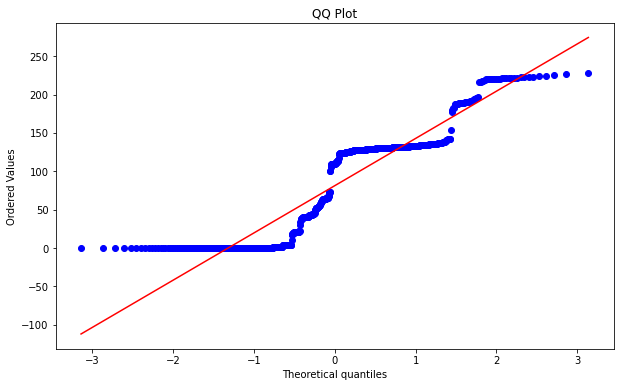

In [36]:
consumption_ranges = df_clean.groupby('Energy_label')['Consumption'].agg(['min', 'max']).reset_index()

# Plotting the ranges
plt.figure(figsize=(10, 6))
for i, label in enumerate(consumption_ranges['Energy_label']):
    plt.plot([label, label], 
             [consumption_ranges.loc[i, 'min'], consumption_ranges.loc[i, 'max']],
             marker='o', markersize=8)

plt.xlabel('Energy Label')
plt.ylabel('Consumption')
plt.title('Range of Consumption Values for Each Energy Label (Quantile Distribution)')
plt.grid(True)
plt.show()

# Display the consumption ranges for each label
print(consumption_ranges)

# Verify the fit visually using a histogram
plt.figure(figsize=(10, 6))
df_clean['Consumption'].hist(bins=30, density=True, alpha=0.6, color='g')

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, df_clean['Consumption'].mean(), df_clean['Consumption'].std())
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram and Normal Distribution Fit")
plt.show()

# QQ plot to verify normality
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(df_clean['Consumption'], dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

#  RF Regression

In [55]:
df_clean['Energy_label_code'] = df_clean['Energy_label'].cat.codes

# Define features and target variable
features = ['Code_Type', 'Compiler_Type', 'Nested_loops', 'Simple_cond', 'Complex_cond', 'Recursion_calls', 'Source_LOC', 'NR_functions', 'NR_param', 'cyc_comp']
target = 'Energy_label_code'

# Ensure all features are numeric
X = df_clean[features].apply(pd.to_numeric, errors='coerce')
y = df_clean[target]

X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = reg_model.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)

# Ensure predictions fall within the range of category codes
y_pred_rounded = np.clip(y_pred_rounded, y.min(), y.max())

# Convert predictions back to categorical labels
y_pred_labels = pd.Categorical.from_codes(y_pred_rounded, categories=['Benchmark', 'A', 'B', 'C', 'D', 'E', 'F'], ordered=True)

# Evaluate the model
REG_mse = mean_squared_error(y_test, y_pred_rounded)
REG_accuracy = accuracy_score(y_test, y_pred_rounded)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {REG_mse}")
print(f"Accuracy: {REG_accuracy}")
print(f"r2 score: {r2}")


Mean Squared Error: 0.3271604938271605
Accuracy: 0.7098765432098766
r2 score: 0.9032320048762292


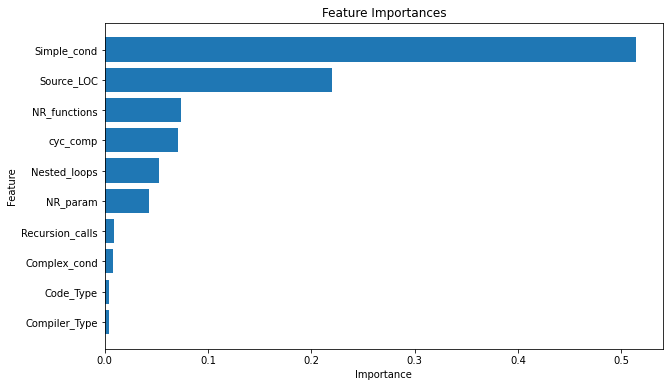

In [39]:
# Plot feature importances
feature_importances = reg_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# RF Classification

In [60]:
# Train a classifier model
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_model.predict(X_test)

clf_accuracy = accuracy_score(y_test, y_pred)
clf_mse = mean_squared_error(y_test, y_pred)
clf_f1_weighted = f1_score(y_test, y_pred, average='weighted')
clf_f1_macro = f1_score(y_test, y_pred, average='macro')
clf_f1_micro = f1_score(y_test, y_pred, average='micro')

print(f"Accuracy: {clf_accuracy}")
print(f"Weighted F1 Score: {clf_f1_weighted}")

# Convert predictions back to categorical labels
y_pred_labels = pd.Categorical.from_codes(y_pred, categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)

Accuracy: 0.7098765432098766
Weighted F1 Score: 0.6535150716486546


# Note
On last day before uploading to Github accuracy of RF regressor + RF classifier decreased from 0.740741 to 0.7098765432098766. What happened is unsure but this change happened after finishing the thesis.

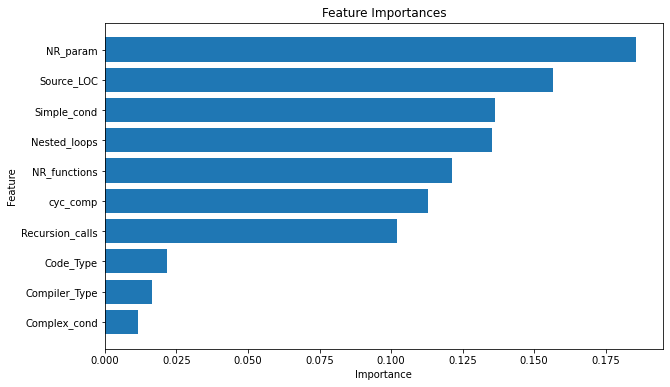

In [27]:
# Plot feature importances
feature_importances = clf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# NN Classifier

In [19]:
df_clean['Energy_label_code'] = df_clean['Energy_label'].cat.codes

# Define features and target variable
features = ['Nested_loops', 'Simple_cond', 'Complex_cond', 'Source_LOC', 'NR_functions', 'NR_param', 'cyc_comp']
target = 'Energy_label_code'

# Ensure all features are numeric
X = df_clean[features].apply(pd.to_numeric, errors='coerce')
y = df_clean[target]

# Check for any NaN values and drop them
X = X.dropna()
y = y[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(6, activation='softmax')  # 6 classes for the energy labels
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

# Evaluate the model on the test set
loss, NNC_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {NNC_accuracy}")

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert predictions back to categorical labels
y_test_labels = pd.Categorical.from_codes(y_test, categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)
y_pred_labels = pd.Categorical.from_codes(y_pred, categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))
overall_f1_score = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall F1 Score: {overall_f1_score}")

overall_recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall Recall: {overall_recall}")



Epoch 1/100


/home/timothytoonen/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2595 - loss: 1.6982 - val_accuracy: 0.5581 - val_loss: 1.5839
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5995 - loss: 1.5183 - val_accuracy: 0.5736 - val_loss: 1.4529
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6628 - loss: 1.3587 - val_accuracy: 0.6589 - val_loss: 1.3114
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7079 - loss: 1.2152 - val_accuracy: 0.6589 - val_loss: 1.1623
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7312 - loss: 1.0389 - val_accuracy: 0.6589 - val_loss: 1.0205
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6591 - loss: 0.9408 - val_accuracy: 0.6512 - val_loss: 0.8961
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7001 - loss: 0.8080 - val_accuracy: 0.6589 - val_loss: 0.7970
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7221 - loss: 0.7334 - val_accuracy: 0.6589 - val_loss: 0.7

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7442 - loss: 0.5466 
Test Loss: 0.5203609466552734
Test Accuracy: 0.7407407164573669
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           A       0.94      1.00      0.97        29
           B       1.00      0.90      0.95        21
           C       0.94      1.00      0.97        32
           D       0.46      0.88      0.60        33
           E       0.00      0.00      0.00        26
           F       0.73      0.52      0.61        21

    accuracy                           0.74       162
   macro avg       0.68      0.72      0.68       162
weighted avg       0.67      0.74      0.69       162

Overall F1 Score: 0.6900275907220351
Overall Recall: 0.7407407407407407


/home/timothytoonen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/timothytoonen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/timothytoonen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


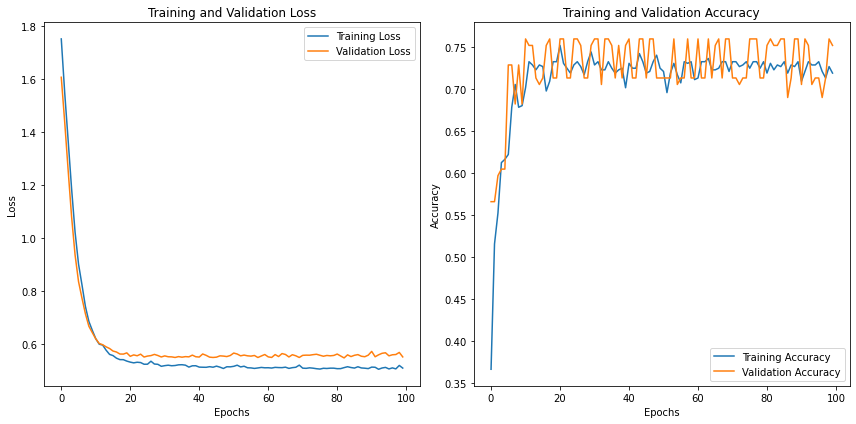

In [46]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# NB Classifier

In [47]:
df_clean['Energy_label_code'] = df_clean['Energy_label'].cat.codes

# Define features and target variable
features = ['Code_Type', 'Compiler_Type', 'Nested_loops', 'Simple_cond', 'Complex_cond', 'Recursion_calls', 'Source_LOC', 'NR_functions', 'NR_param', 'cyc_comp']
target = 'Energy_label_code'

# Ensure all features are numeric
X = df_clean[features].apply(pd.to_numeric, errors='coerce')
y = df_clean[target]

# Check for any NaN values and drop them
X = X.dropna()
y = y[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Naive Bayes classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_model.predict(X_test)

# Convert predictions back to categorical labels
y_test_labels = pd.Categorical.from_codes(y_test, categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)
y_pred_labels = pd.Categorical.from_codes(y_pred, categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))

# Print accuracy
NB_accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {NB_accuracy}")

overall_f1_score = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall F1 Score: {overall_f1_score}")

overall_recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print(f"Overall Recall: {overall_recall}")


              precision    recall  f1-score   support

           A       0.62      1.00      0.76        29
           B       1.00      0.76      0.86        21
           C       0.62      0.25      0.36        32
           D       0.00      0.00      0.00        33
           E       0.32      0.92      0.47        26
           F       0.60      0.29      0.39        21

    accuracy                           0.51       162
   macro avg       0.52      0.54      0.47       162
weighted avg       0.49      0.51      0.44       162

Accuracy: 0.5123456790123457
Overall F1 Score: 0.4446657115001231
Overall Recall: 0.5123456790123457


/home/timothytoonen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/timothytoonen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/timothytoonen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
accuracy_scores = [NB_accuracy, NNC_accuracy, clf_accuracy, REG_accuracy]
accuracy_df = pd.DataFrame(list(accuracy_scores), columns=['Accuracy'])
accuracy_df['Model'] = ['Naive bayes', 'NN Class', 'RF Classification', 'RF Regression']
accuracy_df

,Accuracy,Model
0,0.512346,Naive bayes
1,0.716049,NN Class
2,0.709877,RF Classification
3,0.709877,RF Regression


***Evaluation***

In [42]:
def make_prediction(input_data):
    input_df = pd.DataFrame([input_data], columns=features)
    input_df = input_df.apply(pd.to_numeric, errors='coerce')
    input_df = input_df.dropna()
    
    if input_df.empty:
        return "Invalid input data"
    
    # Standardize the input data
    input_scaled = scaler.transform(input_df)
    
    # Make a prediction
    pred = reg_model.predict(input_scaled)
    pred_rounded = np.round(pred).astype(int)
    pred_rounded = np.clip(pred_rounded, y.min(), y.max())
    
    # Convert prediction to categorical label
    pred_label = pd.Categorical.from_codes(pred_rounded, categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)
    
    return pred_label[0]

# Example input data for prediction
example_input = {
    'Code_Type': 1,
    'Compiler_Type': 1,
    'Nested_loops': 2,
    'Simple_cond': 3,
    'Complex_cond': 0,
    'Recursion_calls': 2,
    'Source_LOC': 102,
    'NR_functions': 3,
    'NR_param': 5,
    'cyc_comp': 7
}

predicted_label = make_prediction(example_input)
print(f"Predicted Energy Label: {predicted_label}")

Predicted Energy Label: B


/home/timothytoonen/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
